# Variational Autoencoder (VAE) con PyTorch

En este *notebook* en texto plano, crearemos y entrenaremos un **Variational Autoencoder (VAE)** para el dataset **MNIST**. Luego, mostraremos cómo generar nuevas imágenes a partir del espacio latente y cómo explorar el espacio intermedio entre dos imágenes de diferentes categorías.

## ¿Qué es un VAE?

Un **Autoencoder Variacional (VAE)** es un modelo generativo que aprende a:

1. **Codificar** (encode) una entrada $x$ en una representación latente $z$ que sigue una distribución normal.
2. **Decodificar** (decode) dicha representación latente $z$ para reconstruir $x$.

Esto se logra con una arquitectura de red neuronal que produce:
- **Media** $\mu(x)$ del espacio latente
- **Desviación estándar** $\sigma(x)$ del espacio latente

El objetivo es poder muestrear valores de $z$ durante el entrenamiento y la inferencia, de forma que podamos generar nuevas muestras al decodificarlas.

## Función de pérdida en un VAE

La función de pérdida se compone de dos términos principales: la **pérdida de reconstrucción** y la **divergencia KL** (*Kullback–Leibler*):

$$
\mathcal{L} = \mathcal{L}_{\text{reconstrucción}} + \mathcal{D}_{\text{KL}}\big(q_\phi(z|x) \parallel p_\theta(z)\big)
$$

1. **Pérdida de reconstrucción**: puede ser el error de entropía cruzada o MSE entre la imagen real $x$ y la reconstruida $\hat{x}$. Para MNIST se suele usar *Binary Cross-Entropy* (BCE) asumiendo que los píxeles están en $[1,1]$.

$$
\mathcal{L}_{\text{reconstrucción}} = -\mathbb{E}_{q_\phi(z|x)} \big[\log p_\theta(x|z)\big]
$$

2. **Divergencia KL**: mide qué tanto se desvía la distribución aproximada $q_\phi(z|x)$ de la distribución prior $p_\theta(z)$ (normal estándar). Se calcula por:

$$
\mathcal{D}_{\text{KL}}\big(q_\phi(z|x) \parallel p_\theta(z)\big) = \frac{1}{2} \sum_{j=1}^{d} \big( \mu_j^2 + \sigma_j^2 - \log(\sigma_j^2) - 1 \big)
$$

El hiperparámetro $\beta$ (en VAEs *$\beta$-VAE) puede ponderar la contribución de $\mathcal{D}_{\text{KL}}$, pero en su forma clásica se toma $\beta = 1$.

In [1]:
######################################################
# BLOQUE 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIONES
######################################################

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Verificamos disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


## Definición del Modelo VAE

Definimos la **arquitectura** de nuestro VAE. Tendremos:

- Un **encoder** que reduce el tamaño de la imagen de 784 (28x28) a un espacio latente de dimensión `latent_dim`.
- Un **decoder** que toma una muestra $z$ del espacio latente y produce una imagen reconstruida de 784 valores (28x28).

En el **encoder** obtendremos dos salidas: 
- $\mu$: la media de la distribución latente
- $\log(\sigma^2)$: (o bien $\log \sigma$) la desviación estándar en log.

Luego, muestreamos $z$ como:
$$
z = \mu + \exp\left(\frac{\log(\sigma^2)}{2}\right) \cdot \epsilon
$$
donde $\epsilon \sim \mathcal{N}(0, I)$.

In [2]:
##################################
# BLOQUE 2: DEFINICIÓN DE LA RED
##################################

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        
        self.mu_layer = nn.Linear(200, latent_dim)       # media
        self.logvar_layer = nn.Linear(200, latent_dim)   # log-variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()  # asumimos salida en [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # mu: media
        # logvar: log(var)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # se muestrea epsilon de una Normal
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

## Definición de la Función de Pérdida del VAE

Como comentamos, la función de pérdida tiene dos términos:
1. **BCE o MSE** para la reconstrucción.
2. **KL-Divergence**.

La pérdida total es:

$$
\text{Loss} = \text{BCE}(x, \hat{x}) + \alpha \cdot \text{KL}(\mu, \log \sigma^2)
$$

Donde $\alpha = 1$ normalmente, pero se puede ajustar.

In [3]:
#########################################
# BLOQUE 3: FUNCIÓN DE PÉRDIDA DEL VAE
#########################################

def vae_loss(recon_x, x, mu, logvar):
    # recon_x: salida de la red (batch_size, 784)
    # x: entrada original (batch_size, 784)
    
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence = 0.5 * sum( mu^2 + exp(logvar) - logvar - 1 )
    # logvar = log(sigma^2)
    KL = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - logvar - 1)
    
    return BCE + KL

## Carga del Dataset MNIST

Usaremos *torchvision* para cargar **MNIST**. Normalizaremos los valores de entrada a $[0,1]$. El dataset consiste en imágenes 28x28 de dígitos (0-9).

In [4]:
#######################################
# BLOQUE 4: CARGA DE DATOS DE MNIST
#######################################

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()  # convierte [0, 255] a [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Entrenamiento del VAE

Entrenaremos el VAE por varias épocas. En cada iteración, pasaremos un *batch* al modelo, calcularemos la pérdida y realizaremos el *backpropagation* para actualizar los pesos.

In [5]:
######################################
# BLOQUE 5: ENTRENAMIENTO DEL MODELO
######################################

latent_dim = 20
lr = 1e-3
epochs = 10

model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)  # aplanamos
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 180.1150
Epoch [2/10], Loss: 130.4651
Epoch [3/10], Loss: 118.4127
Epoch [4/10], Loss: 113.2823
Epoch [5/10], Loss: 110.3909
Epoch [6/10], Loss: 108.5315
Epoch [7/10], Loss: 106.9903
Epoch [8/10], Loss: 105.8745
Epoch [9/10], Loss: 105.0081
Epoch [10/10], Loss: 104.3120


## Visualización de la Evolución de la Pérdida

Podemos graficar cómo se comporta la pérdida en el tiempo para verificar la convergencia del modelo.

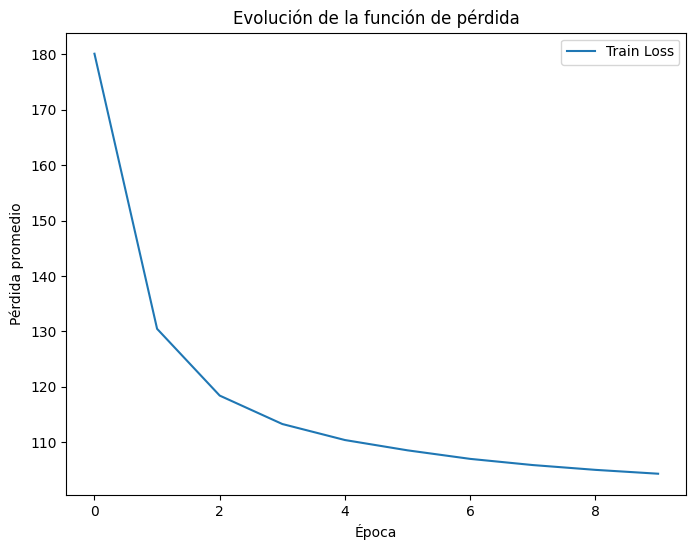

In [6]:
##########################################
# BLOQUE 6: GRÁFICO DE LA FUNCIÓN DE PÉRDIDA
##########################################
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.title("Evolución de la función de pérdida")
plt.xlabel("Época")
plt.ylabel("Pérdida promedio")
plt.legend()
plt.show()

## Reconstrucción de Imágenes

Veamos algunas reconstrucciones del conjunto de prueba (test). Tomamos algunas imágenes, las pasamos por el VAE y graficamos la imagen original y la reconstruida.

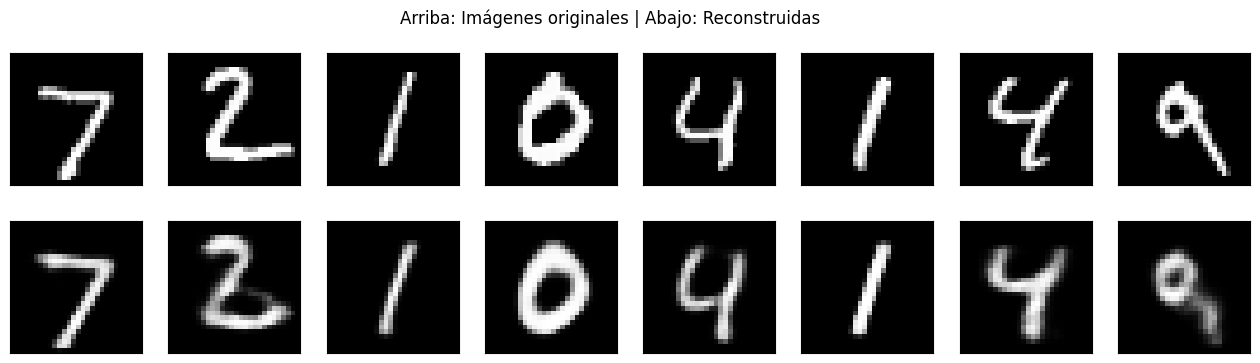

In [7]:
###########################################################
# BLOQUE 7: RECONSTRUCCIÓN DE ALGUNAS IMÁGENES DE TEST
###########################################################
model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.view(-1, 28*28).to(device)

with torch.no_grad():
    recon_images, _, _ = model(images)

# Pasamos a CPU y convertimos a numpy para graficar
images = images.cpu().numpy()
recon_images = recon_images.cpu().numpy()

n = 8  # número de imágenes a mostrar
plt.figure(figsize=(16,4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstruida
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_images[i].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Arriba: Imágenes originales | Abajo: Reconstruidas")
plt.show()

## Generación de Nuevas Imágenes

Para generar imágenes desde el VAE, podemos muestrear valores $z \sim \mathcal{N}(0,I)$ y decodificarlos con nuestro `decoder`.

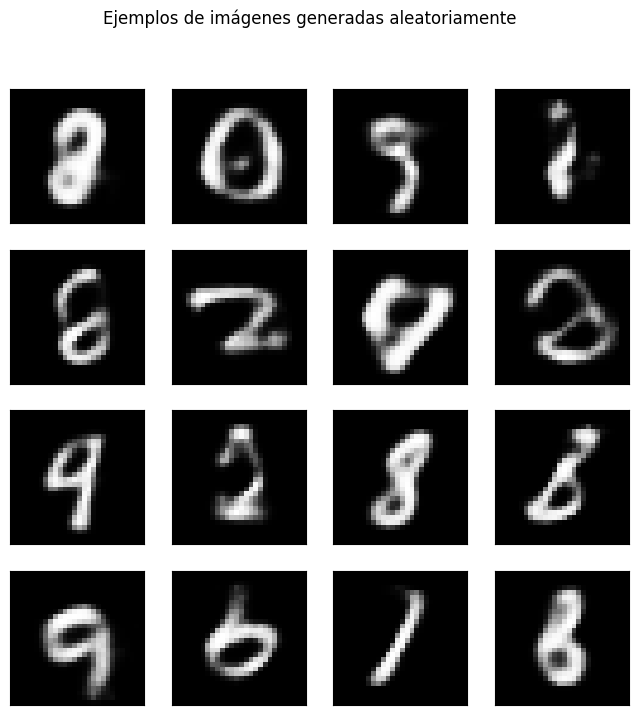

In [8]:
################################################
# BLOQUE 8: GENERACIÓN DE NUEVAS IMÁGENES
################################################
model.eval()
with torch.no_grad():
    # Sample z from Normal(0, 1)
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z).cpu().numpy()

# Graficar algunas de esas imágenes
n = 16
plt.figure(figsize=(8,8))
for i in range(n):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Ejemplos de imágenes generadas aleatoriamente")
plt.show()

## Interpolación en el Espacio Latente

Por último, realizaremos un experimento para *interpolar* entre dos imágenes de distintas categorías. Para ello:
1. Tomamos dos imágenes, por ejemplo un `0` y un `7`.
2. Las codificamos para obtener $\mu_1$, $\log(\sigma^2)_1$ y $\mu_2$, $\log(\sigma^2)_2$.
3. Utilizamos sólo $\mu_1$ y $\mu_2$ (por simplicidad) como nuestros puntos en el espacio latente.
4. Creamos puntos intermedios en una línea entre $\mu_1$ y $\mu_2$.
5. Decodificamos esos puntos intermedios y observamos cómo se transforma la imagen.

Para simplificar, ignoramos el muestreo aleatorio y utilizamos $\mu$ directamente.

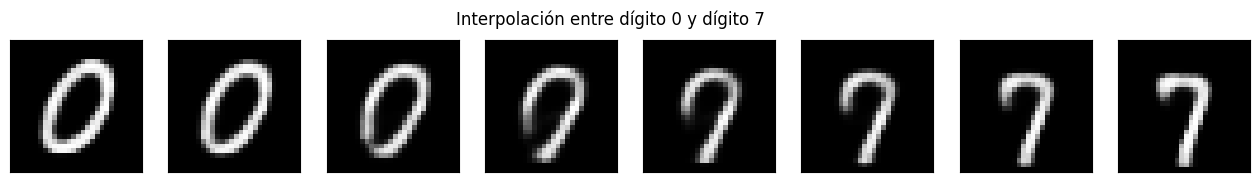

In [45]:
#####################################################
# BLOQUE 9: INTERPOLACIÓN ENTRE DOS DÍGITOS
#####################################################
model.eval()

# Función para obtener la representación latente (mu) de una imagen
def get_latent_representation(model, image):
    with torch.no_grad():
        mu, logvar = model.encode(image)
    return mu

# Seleccionamos dígitos diferentes, por ejemplo 0 y 7
digit1, digit2 = 0, 7

# Buscamos en el dataset de test un ejemplo de '0' y otro de '7'
def get_image_of_digit(dataloader, digit):
    # tomar una al azar...
    while True:
        random_index = np.random.randint(0, len(dataloader.dataset))
        img, lbl = dataloader.dataset[random_index]
        if lbl == digit:
            return img.unsqueeze(0)  # [1,1,28,28]

img_0 = get_image_of_digit(test_loader, digit1).to(device)
img_7 = get_image_of_digit(test_loader, digit2).to(device)

# Aplanamos
img_0_flat = img_0.view(-1, 28*28)
img_7_flat = img_7.view(-1, 28*28)

# Obtenemos mu
mu_0 = get_latent_representation(model, img_0_flat)
mu_7 = get_latent_representation(model, img_7_flat)

n_interpolations = 8
alphas = np.linspace(0, 1, n_interpolations)

interpolated_images = []
with torch.no_grad():
    for alpha in alphas:
        z = (1 - alpha) * mu_0 + alpha * mu_7
        reconstruction = model.decode(z)
        interpolated_images.append(reconstruction.cpu().numpy())

plt.figure(figsize=(16,2))
for i in range(n_interpolations):
    ax = plt.subplot(1, n_interpolations, i+1)
    plt.imshow(interpolated_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle(f"Interpolación entre dígito {digit1} y dígito {digit2}")
plt.show()

In [46]:
# Función para hacer todo lo anterior de un solo paso

def show_interpolation(digit1, digit2, model, test_loader, n_interpolations=8, n_rows=1):
    model.eval()

    img1 = get_image_of_digit(test_loader, digit1).to(device)
    img2 = get_image_of_digit(test_loader, digit2).to(device)

    # Obtenemos mu
    mu1 = get_latent_representation(model, img1.view(-1, 28*28))
    mu2 = get_latent_representation(model, img2.view(-1, 28*28))

    alphas = np.linspace(0, 1, n_interpolations)

    interpolated_images = []
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            reconstruction = model.decode(z)
            interpolated_images.append(reconstruction.cpu().numpy())

    n_cols = n_interpolations // n_rows
    print(f'cols, rows: {n_cols}, {n_rows}')
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    for i in range(n_interpolations):
        ax = axs[i // n_cols, i % n_cols] if n_rows > 1 else axs[i]
        ax.imshow(interpolated_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(f"Interpolación entre dígito {digit1} y dígito {digit2}")
    plt.show()


cols, rows: 8, 1


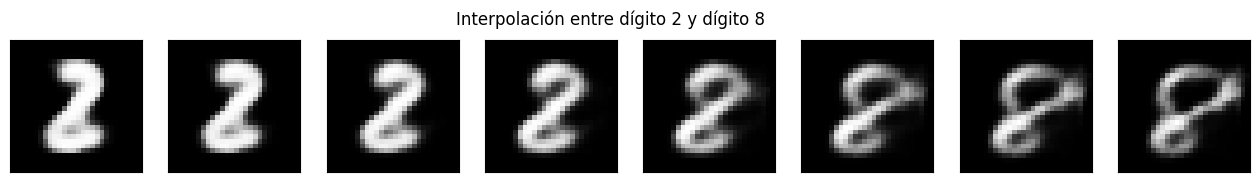

In [49]:
show_interpolation(2, 8, model, test_loader, n_interpolations=8, n_rows=1)

cols, rows: 8, 1


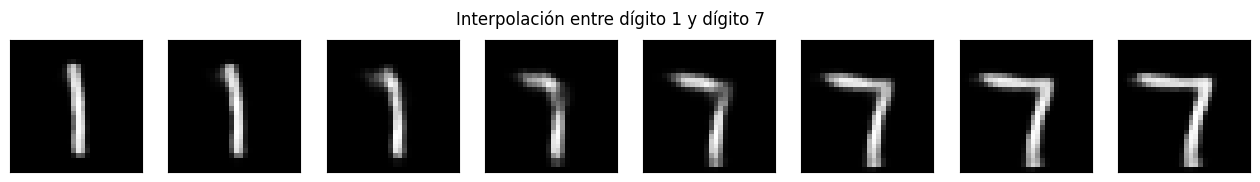

In [60]:
show_interpolation(1, 7, model, test_loader, n_interpolations=8, n_rows=1)